# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from texttable import Texttable
import latextable

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import sys
sys.path.insert(1, '../sar_dirichlet')
import dirichlet_regression

In [4]:
from func_test import cos_similarity, create_features_matrices

In [5]:
scipy.__version__

'1.10.1'

In [7]:
import sys
sys.path.append("../../coral_mapping/")
import segments_regressor
import coral_map_tests

# Loading Maupiti data

In [8]:
X = np.load('../../smote_compositional/data/maupiti_X_for_smote.npy')
Y = np.load('../../smote_compositional/data/maupiti_y_for_smote.npy')
segments = np.load('../../smote_compositional/data/maupiti_segments_for_smote.npy')
indices_segments_keep = np.load('../../smote_compositional/data/maupiti_indices_segments_for_smote.npy')

In [9]:
boundaries = coral_map_tests.find_boundaries(segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(segments, boundaries)

In [10]:
n_features = 16
n_classes = 4
n_samples = X.shape[0]

In [ ]:
from skimage.segmentation import mark_boundaries

In [16]:
B00_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B00.npy')
B01_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B01.npy')
B02_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B02.npy')
B03_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B03.npy')
rugo=np.load('../../water_column/pleiades_rugo.npy')

upperleft_x=573123
upperleft_y=8187427
lowerright_x=584093
lowerright_y=8175645

x_lim_min=574998
x_lim_max=582084
y_lim_min=8177202
y_lim_max=8185046

# On reshape les bandes
B00_corrected=B00_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B01_corrected=B01_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B02_corrected=B02_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B03_corrected=B03_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]

In [17]:
img=np.dstack((B02_corrected, B01_corrected, B00_corrected))

In [18]:
%%time
mask = np.zeros(np.shape(segments))
for i in indices_segments_keep:
    mask[segments == i] = 1

Wall time: 25.7 s


In [19]:
mask = np.array(mask,dtype=bool)
masked_img = np.ma.masked_where(np.dstack(3*[np.bitwise_not(mask)]), img)
mask3 = np.stack((mask,)*3, axis=-1)

In [20]:
marked_boundaries = mark_boundaries(img,segments,color=(1, 0.1, 0.1))

In [23]:
%%time
map_segments = np.zeros(np.shape(segments))
argmax_Y = np.argmax(Y,axis=1)
for i in range(len(Y)):
    map_segments[segments==indices_segments_keep[i]] = argmax_Y[i]+1

Wall time: 55.4 s


In [59]:
segments_of_interest = segments[2300:2480,3200:3380]
map_segments_of_interest = map_segments[2300:2480,3200:3380]

In [25]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

cMap = []
for value, colour in zip([0,1,2,3,4],["tab:grey", "tab:orange", "tab:pink", "tab:blue", "tab:green"]):
    cMap.append((value/4, colour))

customColourMap = LinearSegmentedColormap.from_list("custom", cMap)

bounds = np.linspace(0, 5, 6)
norm = mpl.colors.BoundaryNorm(bounds, customColourMap.N)

In [60]:
normalized_map_segments = map_segments_of_interest / map_segments_of_interest.max()
rgb_map_segments = customColourMap(normalized_map_segments)[:, :, :3]  # Get RGB values (ignore alpha)

In [100]:
# Create an alpha channel based on the argmax of Y[k]
alpha_channel = np.zeros_like(segments_of_interest, dtype=np.float32)

for k in np.unique(segments_of_interest):
    alpha_value = np.max(Y[np.where(indices_segments_keep == k)[0]])
    alpha_channel[segments_of_interest == k] = alpha_value

alpha_channel = alpha_channel / alpha_channel.max()

rgba_map_segments = np.dstack((rgb_map_segments, alpha_channel))

In [153]:
second_color_segments = np.zeros_like(segments_of_interest)

for k in np.unique(segments_of_interest):
    if np.max(Y[np.where(indices_segments_keep == k)[0]])<1:
        second_color = np.argsort(Y[np.where(indices_segments_keep == k)[0]])[0][-2]
        second_color_segments[segments_of_interest == k] = second_color+1
        
alpha_channel_second = 0.4*np.ones_like(alpha_channel)

second_color_segments = second_color_segments / second_color_segments.max()
rgb_second_color_segments = customColourMap(second_color_segments)[:, :, :3] 
rgba_second_color_segments = np.dstack((rgb_second_color_segments, alpha_channel_second))

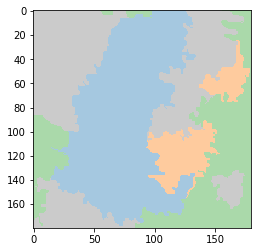

In [154]:
plt.imshow(rgba_second_color_segments, interpolation='None')

In [165]:
# Add boundaries to the RGB part of the image
rgb_with_boundaries = mark_boundaries(rgba_map_segments[:,:,:3], segments_of_interest, color=(1, 0, 0))

# Recombine the RGB with the alpha channel
rgba_with_boundaries = np.dstack((rgb_with_boundaries, rgba_map_segments[:,:,3]))

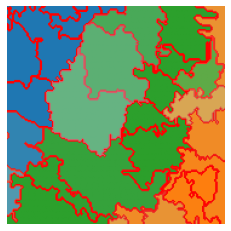

In [169]:
plt.imshow(rgba_second_color_segments, interpolation='None')
plt.imshow(rgba_with_boundaries)
plt.axis('off')
plt.savefig('img_for_graphical_abstract.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

[orange, pink, blue, green]

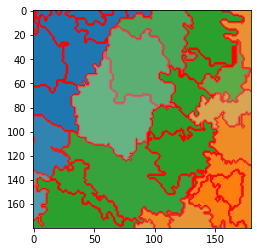

In [170]:
plt.imshow(rgba_second_color_segments, interpolation='None')
plt.imshow(rgba_with_boundaries)
plt.show()

In [91]:
Y[np.where(indices_segments_keep == segments_of_interest[100,1])[0]]

array([[0.        , 0.        , 0.86831913, 0.13168087]])

In [172]:
Y[np.where(indices_segments_keep == segments_of_interest[40,80])[0]]

array([[0.        , 0.        , 0.39390387, 0.60609613]])

In [76]:
Y[np.where(indices_segments_keep == segments_of_interest[80,60])[0]]

array([[0.        , 0.        , 0.48124399, 0.51875601]])

In [85]:
Y[np.where(indices_segments_keep == segments_of_interest[150,100])[0]]

array([[0.        , 0.        , 0.08501177, 0.91498823]])

In [78]:
Y[np.where(indices_segments_keep == segments_of_interest[110,160])[0]]

array([[0.84461326, 0.        , 0.        , 0.15538674]])

In [83]:
Y[np.where(indices_segments_keep == segments_of_interest[170,130])[0]]

array([[0.75526024, 0.        , 0.        , 0.24473976]])